Note that, to run this notebook, you will need to install pyDRTtools. I have done so by cloning the repo and using pip install -e.

In [68]:
import pyDRTtools
from pyDRTtools import runs

from nanodrt.drt_solver.drt import DRT
from nanodrt.fitting.optimizer import Optimizer
from nanodrt.drt_solver.measurements import ImpedenceMeasurement
from nanodrt.drt_solver.utils import (ZARC, 
                                 gamma_ZARC)
from nanodrt.plotting.plots import Plot

import jax.numpy as jnp 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Union

import seaborn as sns

In [101]:
def show_DRT_nyquist(
    f: Union[np.ndarray, jnp.ndarray], 
    Z_measured_re: Union[np.ndarray, jnp.ndarray], 
    Z_measured_im: Union[np.ndarray, jnp.ndarray], 
    tau_list: Union[Union[np.ndarray, jnp.ndarray], List[Union[np.ndarray, jnp.ndarray]]], 
    gamma_list: Union[Union[np.ndarray, jnp.ndarray], List[Union[np.ndarray, jnp.ndarray]]], 
    Z_fit_re: Union[Union[np.ndarray, jnp.ndarray], List[Union[np.ndarray, jnp.ndarray]]], 
    Z_fit_im: Union[Union[np.ndarray, jnp.ndarray], List[Union[np.ndarray, jnp.ndarray]]],
    labels: Union[str, List[str]] = "DRT", 
    ) -> None:
    """
    Plot DRT Spectrum and Nyquist plot.

    Args:
        f (ArrayType): Range of frequencies used to determine integrand values.
        Z_measured_re (ArrayType): Real part of measured impedance.
        Z_measured_im (ArrayType): Imaginary part of measured impedance.
        tau_list (Union[ArrayType, List[ArrayType]]): List of tau arrays for multiple data sets or a single tau array.
        gamma_list (Union[ArrayType, List[ArrayType]]): List of gamma arrays for multiple data sets or a single gamma array.
        labels (Union[str, List[str]]): List of labels for each tau and gamma set or a single label.
        Z_fit_re (Union[ArrayType, List[ArrayType]]): List of real parts of fitted impedance or a single array.
        Z_fit_im (Union[ArrayType, List[ArrayType]]): List of imaginary parts of fitted impedance or a single array.

    Returns:
        None
    """
    
    # Ensure tau_list and gamma_list are lists of arrays
    if isinstance(tau_list, (np.ndarray, jnp.ndarray)) and tau_list.ndim == 1:
        tau_list = [tau_list]
    if isinstance(gamma_list, (np.ndarray, jnp.ndarray)) and gamma_list.ndim == 1:
        gamma_list = [gamma_list]
    
    if isinstance(labels, str):
        labels = [labels]

    if isinstance(Z_fit_re, (np.ndarray, jnp.ndarray)) and Z_fit_re.ndim == 1:
        Z_fit_re = [Z_fit_re]
    if isinstance(Z_fit_im, (np.ndarray, jnp.ndarray)) and Z_fit_im.ndim == 1:
        Z_fit_im = [Z_fit_im]

    # Set the Seaborn style to "whitegrid" for a clean look
    sns.set(style="whitegrid", font="Times New Roman", font_scale=1.5)
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    
    # Iterate over the tau and gamma lists to plot multiple data sets
    for tau, gamma, label in zip(tau_list, gamma_list, labels):
        axs[0].plot(
            tau,
            gamma,
            "-o",
            linewidth=2,
            label=label
        )
    
    # Set labels and title for the first subplot
    axs[0].set_xlabel(r"$\tau \ (s)$", fontsize=16)
    axs[0].set_ylabel(r"$\gamma(\ln \tau) \ (\Omega)$", fontsize=16)
    axs[0].set_title("DRT Spectrum", fontsize=20)
    axs[0].legend(fontsize=16, frameon=False, loc="best")  # Add legend to the first subplot

    # Set x-axis to logarithmic scale
    axs[0].set_xscale("log")

    # Plotting the simulated data
    for Z_re, Z_im, label in zip(Z_fit_re, Z_fit_im, labels):
        axs[1].plot(Z_re, -Z_im, label=label, linewidth=2)

    # Plotting the exact data with markers
    axs[1].plot(
        Z_measured_re,
        -Z_measured_im,
        "o",
        label="Exact Data",
        color="red",
        markersize=6,
    )

    # Set labels and title for the second subplot
    axs[1].set_aspect('equal', adjustable='datalim')  # Ensure aspect ratio is equal
    axs[1].set_xlabel(r"$Z_{re}$ ($\Omega$)", fontsize=16)
    axs[1].set_ylabel(r"$-Z_{im}$ ($\Omega$)", fontsize=16)
    axs[1].set_title("Fitted and Extracted Impedance Values", fontsize=20)

    # Add a legend to the second subplot
    axs[1].legend(fontsize=16, frameon=False, loc="best")

    # Remove top and right spines for a cleaner look
    sns.despine()

    # Adjust the figure layout for better spacing
    fig.tight_layout()

    # Save the plot with high resolution
    # plt.savefig("nature_journal_combined_plot.png", dpi=300)

    # Display the plot
    plt.show()


In [2]:
# Upload the Data and create a Measurement Object 

#columns = ["f", "Z_re", "Z_im"]
df = pd.read_csv("data/single_ZARC.csv")

df = pd.read_csv("data/ed_data_1.csv",)

# nanoDRT

2.0529053842931093e-05


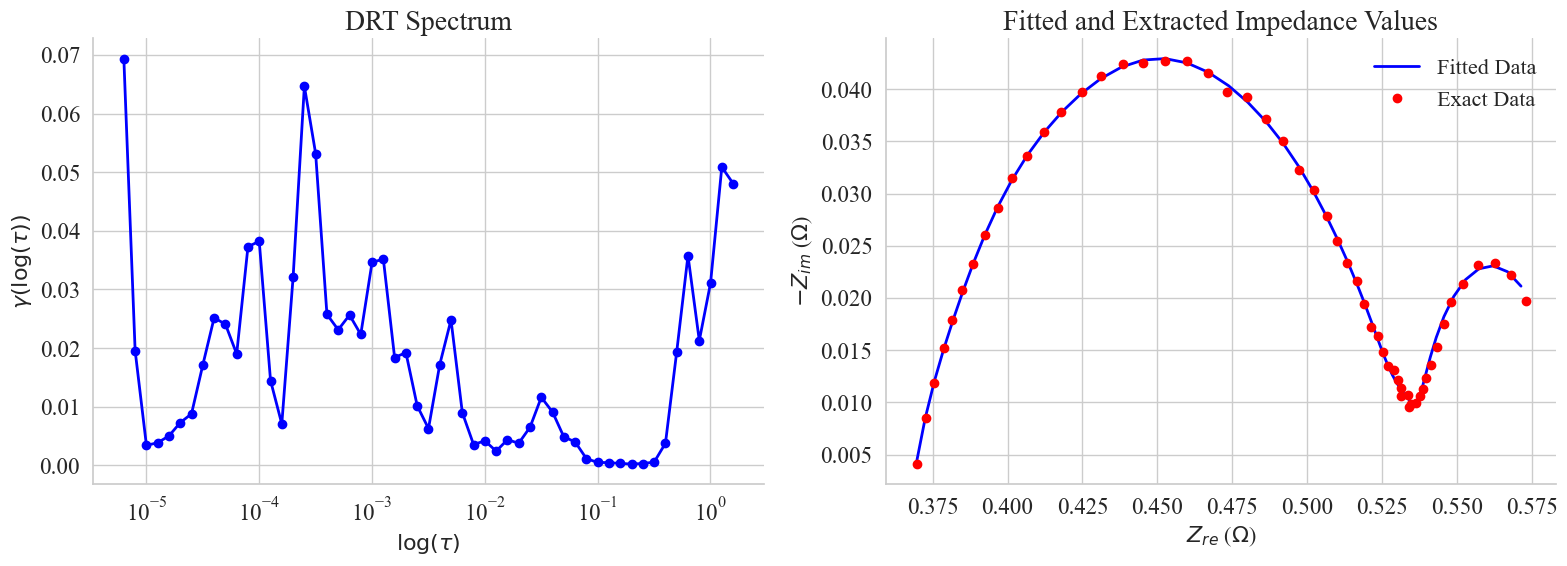

In [49]:
# nanoDRT

f = df["f"].values
tau = 1./(2*jnp.pi*f)
#tau = jnp.flip(jnp.logspace(-4, 4, 500))

Z_exact_re =  df["Z_re"].values 
Z_exact_im =  df["Z_im"].values

# Create our measurement object
measurement = ImpedenceMeasurement(Z_exact_re, Z_exact_im, f)

# Create initial gamma guess
gamma_guess = gamma_ZARC(tau, R_ct=33, tau_0=.2, phi= .7) # Guessing function for the DRT initially assume a guassian single ZARC Model 

# Create initial DRT object
drt = DRT(R_inf= 10, L_0=0, gamma=gamma_guess, tau=tau)

# Build optimiser
solver_dict = {"init_lbd": 1e-4, "lbd_selection": None, 'maxiter': 5e4}
optim = Optimizer(drt=drt, measurement=measurement, solver="regression", integration_method="rbf", solver_dict = solver_dict, rbf_function="guassian")
final_sim = optim.run()
print(final_sim.value)

# Plot result
plot = Plot(final_sim, measurement)
plot.show()

# extract values for comparison


# pyDRTtools

custom
     pcost       dcost       gap    pres   dres
 0: -1.3171e+01 -1.3953e+01  8e-01  0e+00  7e-02
 1: -1.3173e+01 -1.3190e+01  2e-02  6e-17  1e-03
 2: -1.3174e+01 -1.3175e+01  1e-03  1e-16  8e-05
 3: -1.3174e+01 -1.3174e+01  1e-04  2e-16  4e-06
 4: -1.3174e+01 -1.3174e+01  3e-05  6e-17  2e-07
 5: -1.3174e+01 -1.3174e+01  7e-06  6e-17  7e-17
 6: -1.3174e+01 -1.3174e+01  1e-06  1e-16  8e-17
 7: -1.3174e+01 -1.3174e+01  2e-07  6e-17  1e-16
 8: -1.3174e+01 -1.3174e+01  2e-08  1e-17  7e-17
 9: -1.3174e+01 -1.3174e+01  5e-09  6e-17  8e-17
10: -1.3174e+01 -1.3174e+01  8e-10  1e-16  8e-17
11: -1.3174e+01 -1.3174e+01  7e-11  2e-17  1e-16
12: -1.3174e+01 -1.3174e+01  2e-12  6e-17  8e-17
13: -1.3174e+01 -1.3174e+01  2e-14  2e-16  1e-16
14: -1.3174e+01 -1.3174e+01  2e-16  6e-17  7e-17
Optimal solution found.
here is x
[3.74224006e-01 5.32347869e-02 7.79594789e-15 6.04198054e-15
 7.13902754e-15 1.16558531e-14 2.88319839e-14 1.41833214e-13
 5.08507878e-02 5.21319091e-04 2.09874631e-02 4.763259

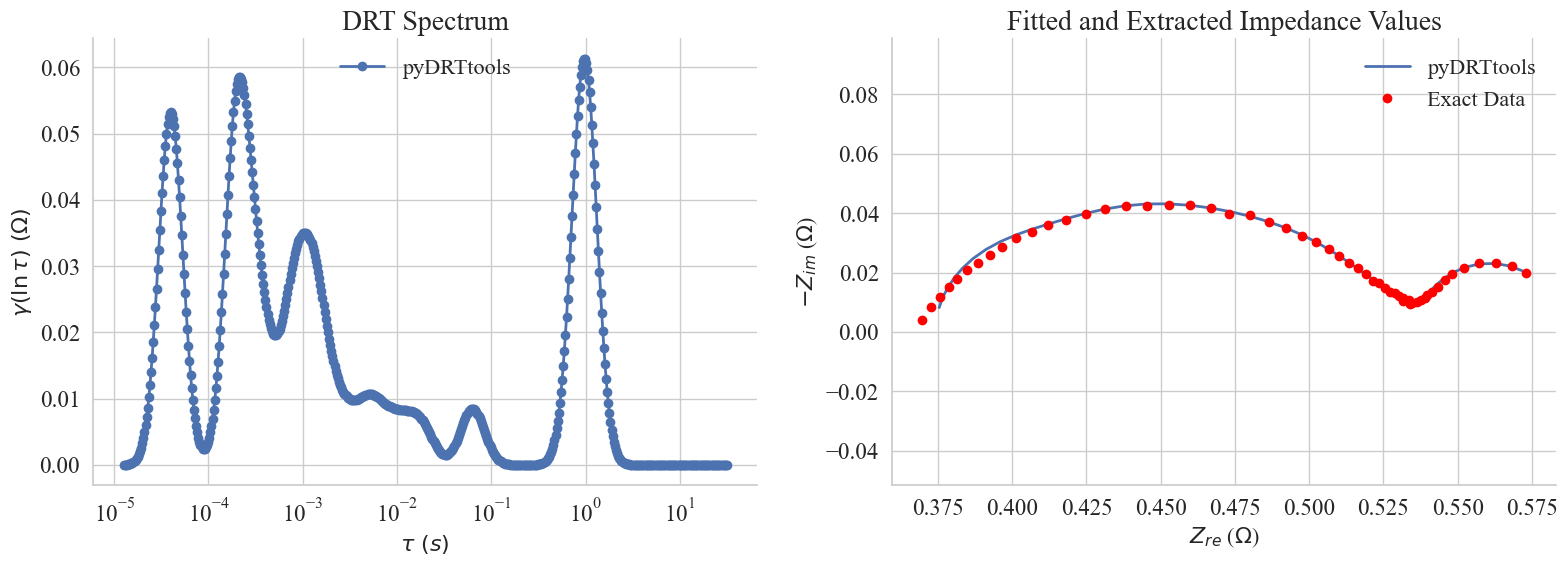

In [102]:
# Load measurement data into EIS_object
pyDRTtools_EIS_object = pyDRTtools.runs.EIS_object(df["f"].values, df["Z_re"].values, df["Z_im"].values)
# this includes tau definition of 
# # self.tau = 1/freq # we assume that the collocation points equal to 1/freq as default
# # self.tau_fine  = np.logspace(log10(self.tau.min())-0.5,log10(self.tau.max())+0.5,10*freq.shape[0])  

# print(pyDRTtools_EIS_object.Z_prime.shape[0])
# print(pyDRTtools_EIS_object.Z_double_prime.shape)
# print(pyDRTtools_EIS_object.freq.shape)
# print(pyDRTtools_EIS_object.Z_exp)

# ridge regression DRT
fitted_entry = pyDRTtools.runs.simple_run(entry=pyDRTtools_EIS_object, rbf_type = 'Gaussian', data_used = 'Combined Re-Im Data', induct_used = 0, der_used = '1st order', cv_type = 'custom', reg_param = 1E-4, shape_control = 'FWHM Coefficient', coeff = 0.333)

#extract fit
out_tau_vec = fitted_entry.out_tau_vec
gamma = fitted_entry.gamma
DRT_Re_Z_data = fitted_entry.mu_Z_re
DRT_Im_Z_data = fitted_entry.mu_Z_im
Z_DRT = DRT_Re_Z_data + 1j*DRT_Im_Z_data
residuals_real = 100*fitted_entry.res_re/np.abs(Z_DRT)
residuals_imag = 100*fitted_entry.res_im/np.abs(Z_DRT)
series_R = fitted_entry.R
series_L = fitted_entry.L 

# something is up obviously. check on how i have been passing data to simple_run in python file. 
# looks like it might work fine with my experimental data? why not with ZARC data? 

show_DRT_nyquist(f=df["f"].values,Z_measured_re=df["Z_re"].values, Z_measured_im=df["Z_im"].values, tau_list=out_tau_vec, gamma_list = gamma, Z_fit_re=DRT_Re_Z_data, Z_fit_im=DRT_Im_Z_data, labels = "pyDRTtools")